In [14]:
import sys
import os
# Adjust the path if needed based on where your src directory is located relative to this notebook
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from src.utils.openFoamUtils import *
from src.utils.data_utils import *
from src.models.tbnn import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

import random

def set_seed(seed=42):
    """Set seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

# Set the seed
set_seed(42)  # You can choose any integer value

Using device: cuda
Random seed set to 42


In [31]:
sequence_length = 25
stride = 10
invariants = ['I1_1', 'I1_3', 'I1_5', 'I1_7', 'I1_13', 'I1_29', 'I1_33', 'q2', 'q3', 'q4']
target = 'bij'
#Create Dataset
X_stacked_846, Y_stacked_846, TB_stacked_846,_,_,y_values_846 = read_dataset(846, sequence_length,stride,invariants=invariants,target=target,filter=5)
X_stacked_1155, Y_stacked_1155, TB_stacked_1155,_,_,y_values_1155 = read_dataset(1155,sequence_length,stride,invariants=invariants,target=target,filter=5)
X_stacked_1475, Y_stacked_1475, TB_stacked_1475,_,_,y_values_1475 = read_dataset(1475,sequence_length,stride,invariants=invariants,target=target,filter=5)

# Exclude the first spatial point (index 0) from X, Y, and TB
X_training = torch.cat([X_stacked_846, X_stacked_1475])[:,:,:,:].to(device)
Y_training = torch.cat([Y_stacked_846, Y_stacked_1475])[:,:,:].to(device)
TB_training = torch.cat([TB_stacked_846, TB_stacked_1475])[:,:,:,:].to(device)

X_validation = X_stacked_1155[:,:,:,:].to(device)
Y_validation = Y_stacked_1155[:,:,:].to(device)
TB_validation = TB_stacked_1155[:,:,:,:].to(device)

In [ ]:
# Hyperparameters
n_features = 10  
n_lstm_hidden = 128      # Increased hidden units in LSTM
n_hidden = 3
hidden_size = 20        # Increased hidden size in linear layers
num_lstm_layers = 2      # Increased number of LSTM layers
bidirectional = False     # Use bidirectional LSTM
n_post_lstm_layers = 2   # Additional fully connected layers after LSTM
output_size = 10
learning_rate = 1e-4
batch_size = 32
dropout = 0.1
num_epochs = 20
criterion = nn.MSELoss()

model = LSTM_TBNN(n_features=n_features,
        n_lstm_hidden=n_lstm_hidden,
        n_hidden=n_hidden,
        hidden_size=hidden_size,
        num_lstm_layers=num_lstm_layers,
        bidirectional=bidirectional,
        n_post_lstm_layers=n_post_lstm_layers,
        output_size=output_size,
        dropout=dropout,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# ... existing code ...

# Create all (t, y) index pairs
T_total, Y_total = X_training.shape[0], X_training.shape[1]
num_points = T_total * Y_total
all_pairs = np.array(np.meshgrid(np.arange(T_total), np.arange(Y_total))).T.reshape(-1, 2)

# Randomly select 20% of pairs for validation
np.random.seed(42)  # For reproducibility
val_indices = np.random.choice(len(all_pairs), size=int(0.2 * len(all_pairs)), replace=False)
train_indices = np.array([i for i in range(len(all_pairs)) if i not in val_indices])

# Get validation and training pairs
val_pairs = all_pairs[val_indices]
train_pairs = all_pairs[train_indices]

print(f"Total pairs: {len(all_pairs)}")
print(f"Training pairs: {len(train_pairs)} ({len(train_pairs)/len(all_pairs)*100:.1f}%)")
print(f"Validation pairs: {len(val_pairs)} ({len(val_pairs)/len(all_pairs)*100:.1f}%)")

# Create sampling weights biased toward the bottom (smaller yix values) for training data
y_indices = train_pairs[:, 1]  # Extract y indices
weights = 1 / (y_indices + 1)  # Higher weight for smaller yix
weights /= weights.sum()  # Normalize weights to sum to 1

best_val_loss = float('inf')  # Initialize with a high value
best_model_state = None       # To store the best model's weights

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    # Sample from training pairs with the biased weights
    batch_indices = np.random.choice(len(train_pairs), size=len(train_pairs), replace=False, p=weights)
    train_pairs_shuffled = train_pairs[batch_indices]

    # Batch loop
    for i in range(0, len(train_pairs), batch_size):
        batch_pairs = train_pairs_shuffled[i:i+batch_size]

        # Extract batch data
        tix_batch = batch_pairs[:, 0]
        yix_batch = batch_pairs[:, 1]

        x_batch = X_training[tix_batch, yix_batch]         # [batch_size, seq_len, features]
        y_batch = Y_training[tix_batch, yix_batch]        # [batch_size, 1]
        TB_batch = TB_training[tix_batch, yix_batch]      # [batch_size, 9, 10]
  
        optimizer.zero_grad()

        y_pred = model(x_batch, TB_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()

        optimizer.step()

        total_loss += loss.item() * batch_pairs.shape[0]  # Weighted loss

    average_loss = total_loss / len(train_pairs)

    # Validation on the held-out pairs
    model.eval()
    val_losses = []
    with torch.no_grad():
        # For validation, we can process in slightly larger batches
        for i in range(0, len(val_pairs), batch_size*2):
            batch_val_pairs = val_pairs[i:i+batch_size*2]
            
            tix_val = batch_val_pairs[:, 0]
            yix_val = batch_val_pairs[:, 1]
            
            x_val = X_training[tix_val, yix_val]
            y_val = Y_training[tix_val, yix_val]
            TB_val = TB_training[tix_val, yix_val]
            
            ypred_val = model(x_val, TB_val)
            val_loss = criterion(ypred_val, y_val)
            val_losses.append(val_loss.item())
            
    val_loss = np.mean(val_losses)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.6f}, Val Loss: {val_loss:.6f}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()  # Save the weights
        print(f'>>> New best model saved at epoch {epoch+1} with Val Loss: {val_loss:.6f}')
        torch.save({
            'model_state_dict': model.state_dict(),
            'hyperparameters': {
                'n_features': n_features,
                'n_lstm_hidden': n_lstm_hidden,
                'n_hidden': n_hidden,
                'hidden_size': hidden_size,
                'num_lstm_layers': num_lstm_layers,
                'bidirectional': bidirectional,
                'n_post_lstm_layers': n_post_lstm_layers,
                'output_size': output_size,
                'dropout': dropout
            }
        }, 'best_model_tbnn_w_hparm.pth')
        print(f'Best model saved with Val Loss: {best_val_loss:.6f}')



Total pairs: 224000
Training pairs: 179200 (80.0%)
Validation pairs: 44800 (20.0%)
Epoch [1/20], Loss: 0.118017, Val Loss: 0.013767
>>> New best model saved at epoch 1 with Val Loss: 0.013767
Best model saved with Val Loss: 0.013767
Epoch [2/20], Loss: 0.018401, Val Loss: 0.008481
>>> New best model saved at epoch 2 with Val Loss: 0.008481
Best model saved with Val Loss: 0.008481
Epoch [3/20], Loss: 0.010835, Val Loss: 0.007999
>>> New best model saved at epoch 3 with Val Loss: 0.007999
Best model saved with Val Loss: 0.007999
Epoch [4/20], Loss: 0.007468, Val Loss: 0.004843
>>> New best model saved at epoch 4 with Val Loss: 0.004843
Best model saved with Val Loss: 0.004843
Epoch [5/20], Loss: 0.005085, Val Loss: 0.003728
>>> New best model saved at epoch 5 with Val Loss: 0.003728
Best model saved with Val Loss: 0.003728
Epoch [6/20], Loss: 0.003931, Val Loss: 0.002805
>>> New best model saved at epoch 6 with Val Loss: 0.002805
Best model saved with Val Loss: 0.002805
Epoch [7/20], Los

In [44]:
x_train_test = X_validation
y_train_test = Y_validation
TB_train_test = TB_validation
#load best model
model.load_state_dict(torch.load('best_model_tbnn_20.pth'))
model.eval()
val_losses = []
y_pred_list = []
rel_errors = []
with torch.no_grad():
    for t in range(x_train_test.shape[0]):
        x_val, y_val = x_train_test[t], y_train_test[t]
        TB_val = TB_train_test[t]
        x_val, y_val, TB_val = x_val, y_val, TB_val
        ypred_val = model(x_val,TB_val)
        #P_val = prod_term_train_test[t]
        #x_val, y_val, TB_val, grad_u_val, P_val = x_val, y_val, TB_val, grad_u_val, P_val
        #s_pred_val = model(x_val, TB_val, grad_u_val)
        #ypred_val = s_pred_val * P_val.view(-1,1) 
        y_pred_list.append(ypred_val.cpu().detach().numpy())
        loss = criterion(ypred_val, y_val)
        #relative error
        # Calculate relative error
        relative_error = np.abs(ypred_val.cpu().detach().numpy() - y_val.cpu().detach().numpy()) / np.abs(y_val.cpu().detach().numpy())
        rel_errors.append(np.mean(relative_error))
        val_losses.append(loss.item())
    #print(f"Loss: {loss.item():.6f}")
# Calculate average loss
avg_loss = np.mean(val_losses)
print(f"Average validation loss: {avg_loss:.6f}")
y_pred_list = np.array(y_pred_list)

Average validation loss: 0.001765


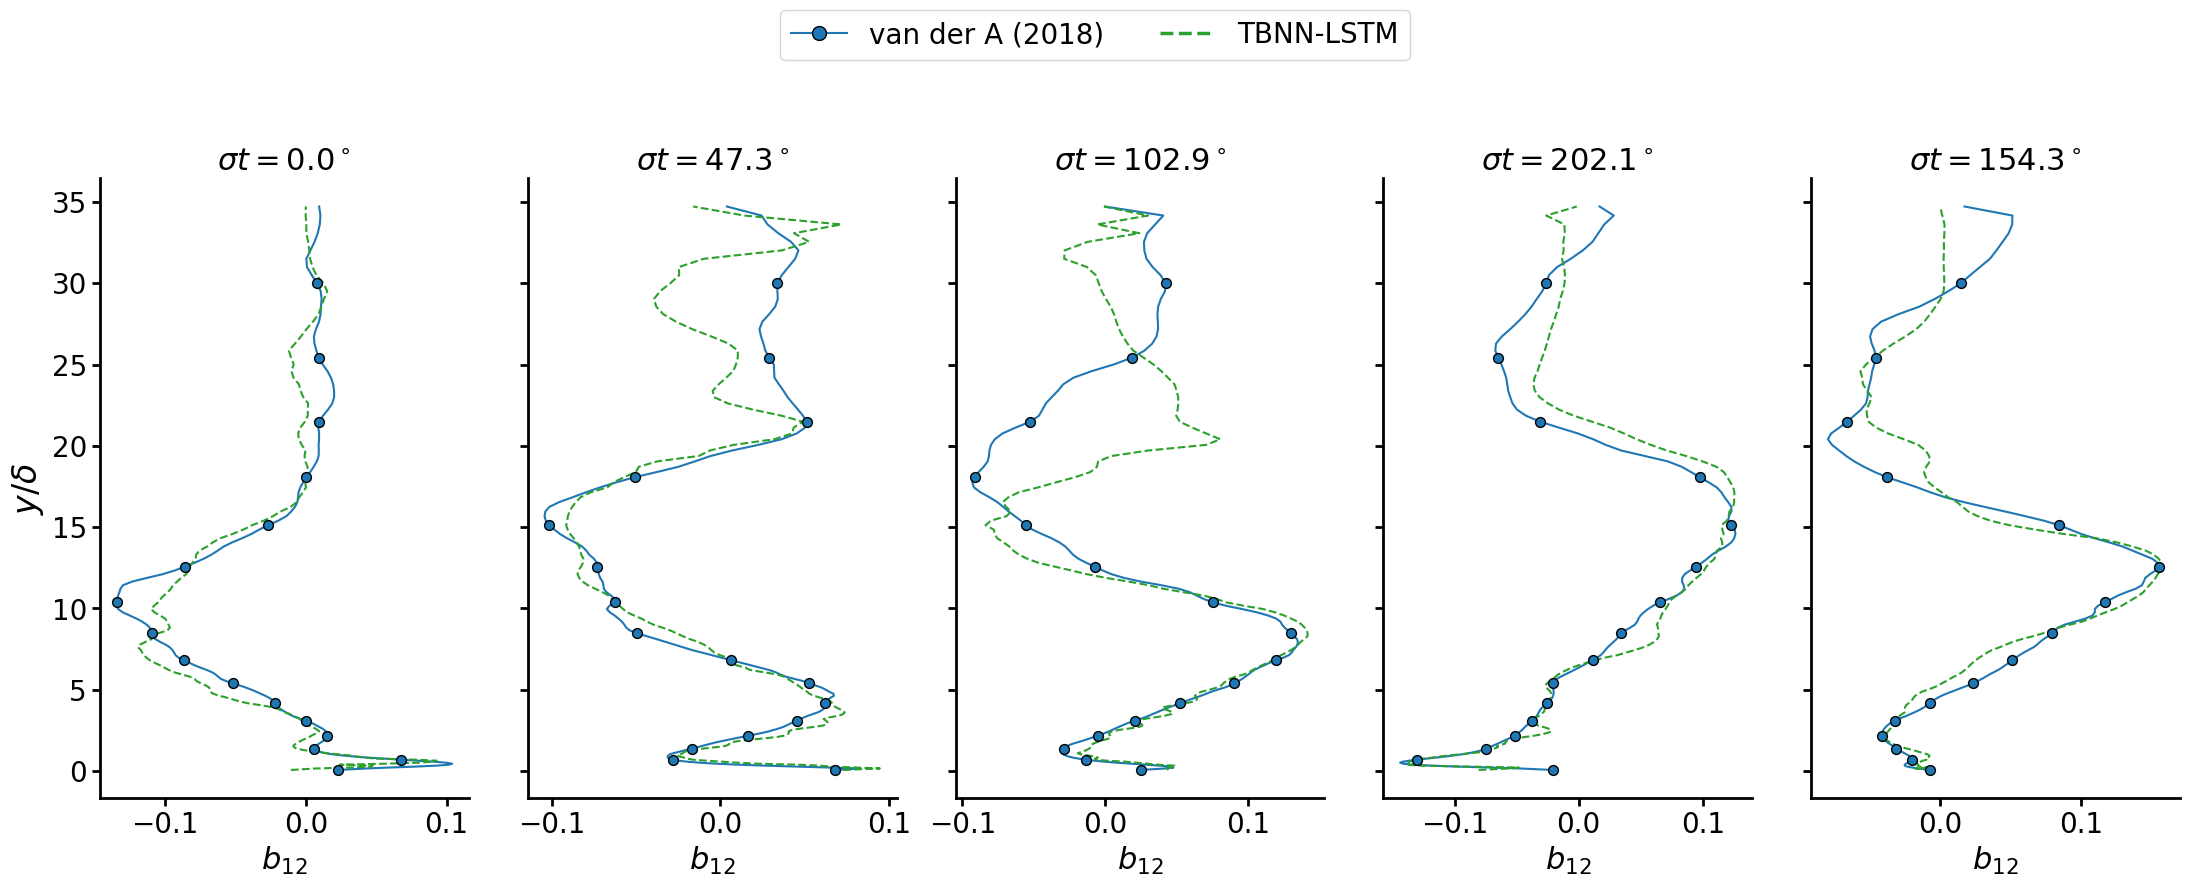

In [46]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
index = 1
components = ['b_{11}', 'b_{12}', 'b_{22}', 'b_{33}']

bij_true = y_train_test.cpu().numpy()
bij_pred = y_pred_list
simulations = {'Re846': {'Re': 846, 'viscosity': 1.029e-6, 'wave_period': 7, 'stokes_layer_thickness': 0.00151, 'max_streamwise_velocity': 0.57},
               'Re1155': {'Re': 1155, 'viscosity': 1.029e-6, 'wave_period': 7, 'stokes_layer_thickness': 0.0015141948719309033, 'max_streamwise_velocity': 0.79},
               'Re1475': {'Re': 1475, 'viscosity': 1.029e-6, 'wave_period': 7, 'stokes_layer_thickness': 0.00151, 'max_streamwise_velocity': 1}}
sim = simulations['Re1155']
Re = sim['Re']
viscosity = sim['viscosity']
stokes_layer_thickness = sim['stokes_layer_thickness']

# Define colors and line styles
colors = ['#1f77b4', '#2ca02c']  # van der A (2018) and TBNN-LSTM
linestyles = ['-', '--']

# Selected time indices for plotting
time_indices = [0,92,200,393,300]
#time_indices = [277, 187, 381, 295, 328]
#time_indices = [316, 531, 486, 539, 376]
sigma = 2 * np.pi / 7  # Assuming sigma corresponds to a full cycle over 7s
dt = 0.01  # time step size in seconds

y_normalized = y_values_846.reshape(700,-1)[0] / stokes_layer_thickness
# Calculate sigma*t in degrees for subplot titles
sigma_t_in_degrees = (np.array(time_indices) * sigma * dt) * (180 / np.pi)

# Set plot size and aesthetics
fig, ax = plt.subplots(1, len(time_indices), figsize=(22, 8), sharey=True)

for idx, time_index in enumerate(time_indices):
    # van der A (2018) Data (Ground Truth)
    ax[idx].plot(
        bij_true[time_index, :,index],
        y_normalized,
        linestyle=linestyles[0], color=colors[0],
        label='van der A (2018)'
    )
    ax[idx].scatter(
        bij_true[time_index, ::10,index],
        y_normalized[::10],
        color=colors[0], marker='o', edgecolor='k', zorder=5, s=50  # Increase marker size
    )

    # TBNN-LSTM Data (Prediction)
    ax[idx].plot(
        bij_pred[time_index, :, index],
        y_normalized,
        linestyle=linestyles[1], color=colors[1],
        label='TBNN-LSTM'
    )

    # Axis styling
    ax[idx].set_xlabel(r"${}$".format(components[index]), fontsize=22, fontweight='bold')
    ax[idx].grid(False)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['right'].set_visible(False)
    ax[idx].spines['left'].set_linewidth(2)
    ax[idx].spines['bottom'].set_linewidth(2)
    ax[idx].tick_params(axis='both', labelsize=20, width=2, length=6)

    # Add title for each subplot
    ax[idx].set_title(rf"$\sigma t = {sigma_t_in_degrees[idx]:.1f}^\circ$", fontsize=22, fontweight='bold')

# Y-axis styling
ax[0].set_ylabel(r"$y/\delta$", fontsize=24, fontweight='bold')

# Custom legend
handles = [
    mlines.Line2D([], [], color=colors[0], linestyle=linestyles[0], marker='o',
                  markerfacecolor=colors[0], markeredgecolor='k', markersize=10, label='van der A (2018)'),
    mlines.Line2D([], [], color=colors[1], linestyle=linestyles[1], linewidth=2.5, label='TBNN-LSTM')
]

fig.legend(handles=handles, loc='upper center', ncol=2, fontsize=20, bbox_to_anchor=(0.5, 1.12))

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save plot
#plt.savefig('../plots/kDeficit_profile.png', bbox_inches='tight', pad_inches=0.1)
#plt.savefig('../plots/kDeficit_profile.pdf', bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

In [50]:
sequence_length = 25
stride = 10
invariants = ['I1_1', 'I1_3', 'I1_5', 'I1_7', 'I1_13', 'I1_29', 'I1_33', 'q2', 'q3', 'q4','krans']
target = 'kDeficit'
#Create Dataset
X_stacked_846, Y_stacked_846, TB_stacked_846,_, gradU_stacked_846,y_values_846 = read_dataset(846, sequence_length,stride,invariants=invariants,target=target,filter=5,gradU_column= 'gradU_0_1')
X_stacked_1155, Y_stacked_1155, TB_stacked_1155,_, gradU_stacked_1155,y_values_1155 = read_dataset(1155,sequence_length,stride,invariants=invariants,target=target,filter=5,gradU_column= 'gradU_0_1')
X_stacked_1475, Y_stacked_1475, TB_stacked_1475,_, gradU_stacked_1475,y_values_1475 = read_dataset(1475,sequence_length,stride,invariants=invariants,target=target,filter=5,gradU_column= 'gradU_0_1')

# Exclude the first spatial point (index 0) from X, Y, and TB
X_training = torch.cat([X_stacked_846, X_stacked_1475])[:,:,:,:].to(device)
Y_training = torch.cat([Y_stacked_846, Y_stacked_1475])[:,:,:].to(device)
TB_training = torch.cat([TB_stacked_846, TB_stacked_1475])[:,:,:,:].to(device)
gradU_training = torch.cat([gradU_stacked_846, gradU_stacked_1475])[:,:,:].to(device)

X_validation = X_stacked_1155[:,:,:,:].to(device)
Y_validation = Y_stacked_1155[:,:,:].to(device)
TB_validation = TB_stacked_1155[:,:,:,:].to(device)
gradU_validation = gradU_stacked_1155[:,:,:].to(device)

In [61]:
class SafeRelativeMSELoss(nn.Module):
    def __init__(self, min_target=0.1):
        super(SafeRelativeMSELoss, self).__init__()
        self.min_target = min_target  # avoid division by very small values

    def forward(self, y_pred, y_true):
        denominator = torch.clamp(y_true, min=self.min_target)  # clamp to min_target
        relative_error = (y_pred - y_true) / denominator
        return torch.mean(relative_error ** 2)

class LogCoshLoss(nn.Module):
    def forward(self, y_pred, y_true):
        loss = torch.log(torch.cosh(y_pred - y_true))
        return torch.mean(loss)

criterion = SafeRelativeMSELoss() #LogCoshLoss() #SafeRelativeMSELoss()

model = LSTM_TBNN_R(
    n_features=10,
    pre_lstm_layers=1,
    n_lstm_hidden=100,
    hidden_size=32,
    num_lstm_layers=1,
    bidirectional=False,
    n_post_lstm_layers=2,
    output_size=10,
    dropout=0.2,
    recurrent_dropout=0,
).to(device)


# Flatten all values
Y_flat = Y_training.view(-1)

# Compute 95th percentile of absolute value
k_scale = torch.quantile(torch.abs(Y_flat), 0.95)

# Normalize
Y_training_norm = Y_training #/ k_scale

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
T_total, Y_total = X_training.shape[0], X_training.shape[1]
num_points = T_total * Y_total  # 1400 x 160 = 224,000
num_epochs = 20
# Create all (t, y) index pairs
all_pairs = np.array(np.meshgrid(np.arange(T_total), np.arange(Y_total))).T.reshape(-1, 2)
# Create sampling weights biased toward the bottom (smaller yix values)
y_indices = all_pairs[:, 1]  # Extract y indices
weights = 1 / (y_indices + 1)  # Higher weight for smaller yix
weights /= weights.sum()  # Normalize weights to sum to 1

best_val_loss = float('inf')  # Initialize with a high value
best_model_state = None       # To store the best model's weights

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    # Shuffle all (t, y) pairs
    #perm = np.random.permutation(num_points)
    #all_pairs_shuffled = all_pairs[perm]
    perm_indices = np.random.choice(len(all_pairs), size=num_points, replace=False, p=weights)
    all_pairs_shuffled = all_pairs[perm_indices]

    # Batch loop
    for i in range(0, num_points, batch_size):
        batch_pairs = all_pairs_shuffled[i:i+batch_size]

        # Extract batch data
        tix_batch = batch_pairs[:, 0]
        yix_batch = batch_pairs[:, 1]

        x_batch = X_training[tix_batch, yix_batch]         # [batch_size, seq_len, features]
        y_batch = Y_training[tix_batch, yix_batch]        # [batch_size, 1]
        TB_batch = TB_training[tix_batch, yix_batch]      # [batch_size, 9, 10]
        gradU_batch = gradU_training[tix_batch, yix_batch] # [batch_size, 1]
        optimizer.zero_grad()

        y_pred = model(x_batch, TB_batch, gradU_batch)
        #s_pred = model(x_batch, TB_batch, gradU_batch)       # Predict scaling factor s
        #y_pred = s_pred * P_batch.view(-1,1) 
        loss = criterion(y_pred, y_batch)
        loss.backward()
        #total_grad_norm = sum(p.grad.norm().item() for p in model.parameters() if p.grad is not None)
        #print(f"Epoch {epoch+1}, Gradient Norm: {total_grad_norm:.6e}")

        optimizer.step()

        total_loss += loss.item() * batch_pairs.shape[0]  # Weighted loss

    average_loss = total_loss / num_points

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for t in range(X_validation.shape[0]):
            x_val, y_val = X_validation[t], Y_validation[t]
            TB_val = TB_validation[t]
            grad_u_val = gradU_validation[t]
            x_val, y_val, TB_val, grad_u_val = x_val, y_val, TB_val, grad_u_val
            ypred_val = model(x_val,TB_val,grad_u_val)
            #s_pred_val = model(x_val, TB_val, grad_u_val)
            #ypred_val = s_pred_val * P_val.view(-1,1) 
            val_loss = criterion(ypred_val, y_val)
            val_losses.append(val_loss.item())
    val_loss = np.mean(val_losses)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()  # Save the weights
        print(f'>>> New best model saved at epoch {epoch+1} with Val Loss: {val_loss:.6f}')
        torch.save({
            'model_state_dict': model.state_dict(),
            'hyperparameters': {
                'n_features': 10,
                'pre_lstm_layers': 1,
                'n_lstm_hidden': 100,
                'hidden_size': 32,
                'num_lstm_layers': 1,
                'bidirectional': False,
                'n_post_lstm_layers': 2,
                'output_size': 10,
                'dropout': 0.2,
                'recurrent_dropout': 0
            }
        }, 'best_model_k_tbnn_w_hparm.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.6f}, Val Loss: {val_loss:.6f}')
    # Save the best model to disk (optional)

>>> New best model saved at epoch 1 with Val Loss: 0.050783
Epoch [1/20], Loss: 0.133844, Val Loss: 0.050783
>>> New best model saved at epoch 2 with Val Loss: 0.046080
Epoch [2/20], Loss: 0.061652, Val Loss: 0.046080
>>> New best model saved at epoch 3 with Val Loss: 0.034393
Epoch [3/20], Loss: 0.040771, Val Loss: 0.034393
>>> New best model saved at epoch 4 with Val Loss: 0.026277
Epoch [4/20], Loss: 0.031479, Val Loss: 0.026277
>>> New best model saved at epoch 5 with Val Loss: 0.020660
Epoch [5/20], Loss: 0.023827, Val Loss: 0.020660
>>> New best model saved at epoch 6 with Val Loss: 0.018858
Epoch [6/20], Loss: 0.020697, Val Loss: 0.018858
>>> New best model saved at epoch 7 with Val Loss: 0.017174
Epoch [7/20], Loss: 0.017421, Val Loss: 0.017174
>>> New best model saved at epoch 8 with Val Loss: 0.015126
Epoch [8/20], Loss: 0.014638, Val Loss: 0.015126
Epoch [9/20], Loss: 0.012941, Val Loss: 0.015324
>>> New best model saved at epoch 10 with Val Loss: 0.014772
Epoch [10/20], Los

In [62]:
checkpoint = torch.load('best_model_k_tbnn_w_hparm.pth')
hyperparameters = checkpoint['hyperparameters']



# Create model with the same architecture
model = LSTM_TBNN_R(**hyperparameters).to(device)
# Load the weights
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
val_losses = []
y_pred_list = []
rel_errors = []
with torch.no_grad():
    for t in range(X_validation.shape[0]):
        x_batch = X_validation[t]
        y_batch = Y_validation[t]
        TB_batch = TB_validation[t]
        gradU_batch = gradU_validation[t]
        
        # Prediction step
        y_pred = model(x_batch, TB_batch, gradU_batch)
        
        # Store predictions
        y_pred_list.append(y_pred.cpu().detach().numpy())
        
        # Calculate loss
        loss = criterion(y_pred, y_batch)
        val_losses.append(loss.item())
        
        # Calculate relative error
        relative_error = np.abs(y_pred.cpu().detach().numpy() - y_batch.cpu().detach().numpy()) / np.abs(y_batch.cpu().detach().numpy())
        rel_errors.append(np.mean(relative_error))
        
# Calculate average loss
avg_loss = np.mean(val_losses)
print(f"Average validation loss: {avg_loss:.6f}")
y_pred_list = np.array(y_pred_list)

Average validation loss: 0.009348


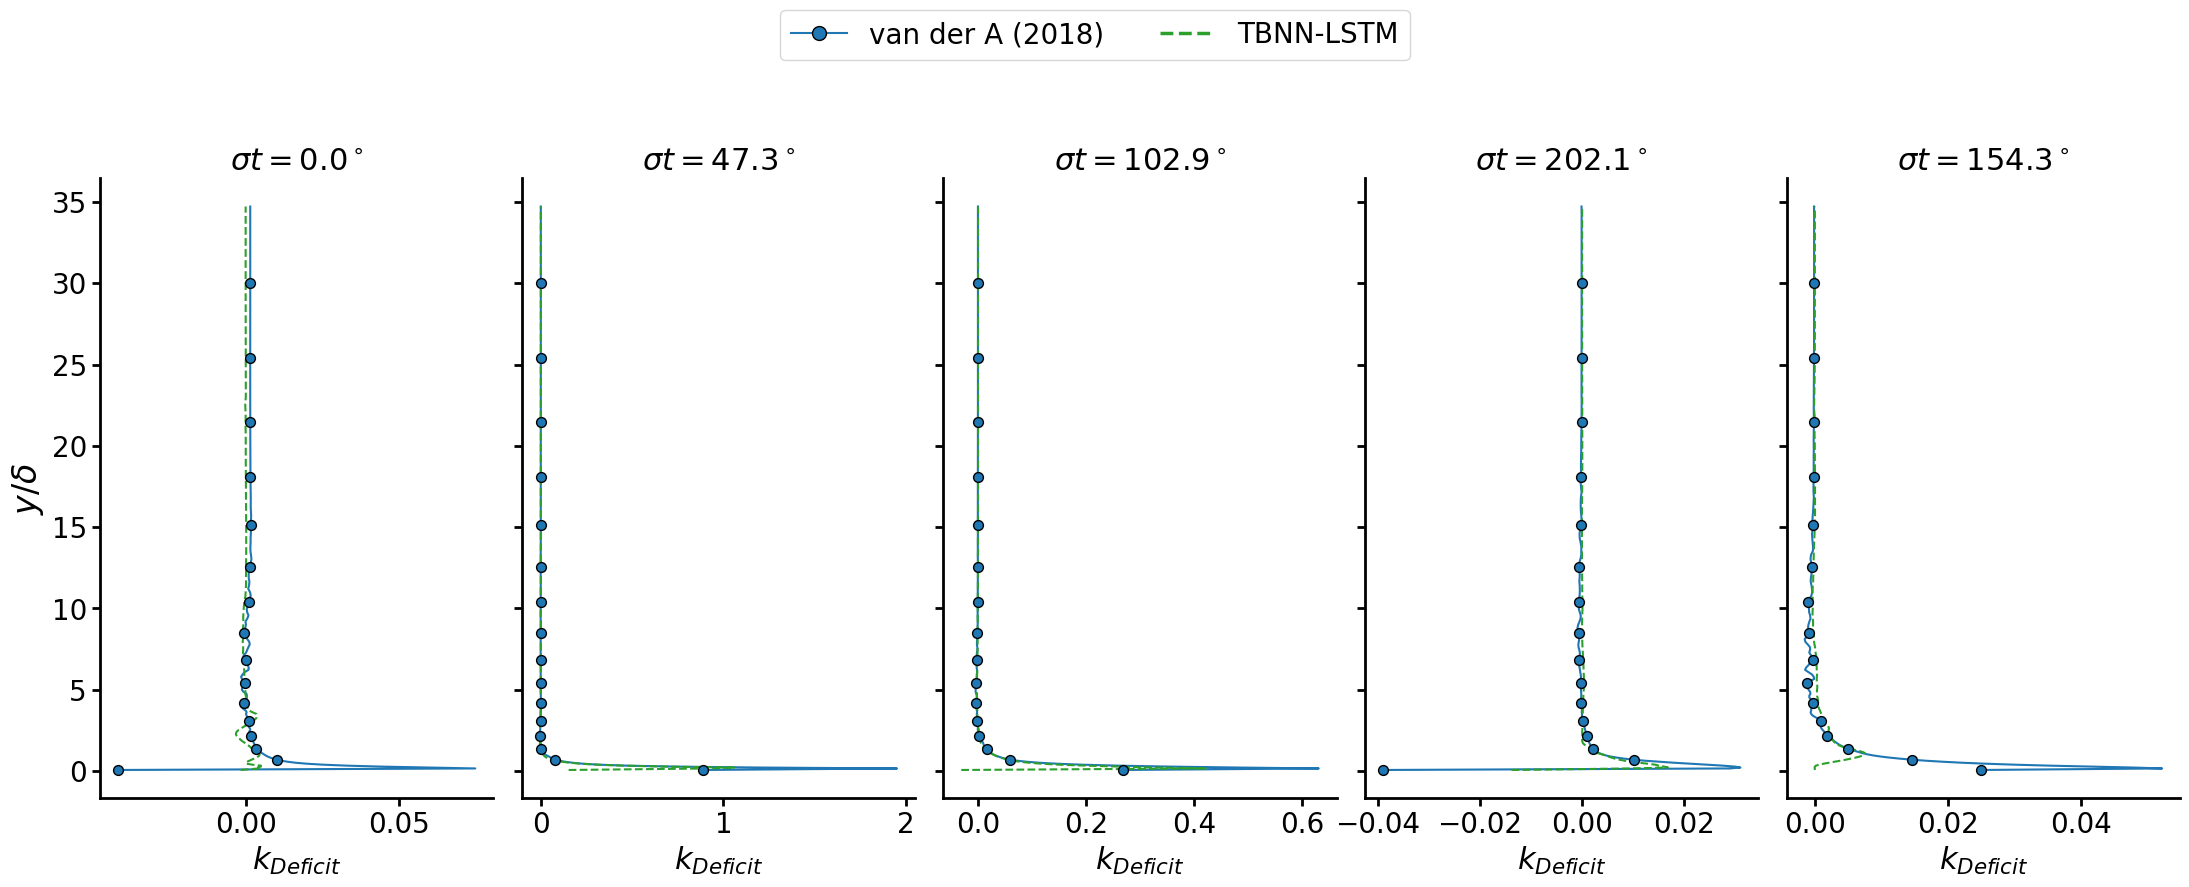

In [63]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
kDeficit_true = Y_validation.cpu().numpy()
kDeficit_pred = y_pred_list
simulations = {'Re846': {'Re': 846, 'viscosity': 1.029e-6, 'wave_period': 7, 'stokes_layer_thickness': 0.00151, 'max_streamwise_velocity': 0.57},
               'Re1155': {'Re': 1155, 'viscosity': 1.029e-6, 'wave_period': 7, 'stokes_layer_thickness': 0.0015141948719309033, 'max_streamwise_velocity': 0.79},
               'Re1475': {'Re': 1475, 'viscosity': 1.029e-6, 'wave_period': 7, 'stokes_layer_thickness': 0.00151, 'max_streamwise_velocity': 1}}
sim = simulations['Re1155']
Re = sim['Re']
viscosity = sim['viscosity']
stokes_layer_thickness = sim['stokes_layer_thickness']

# Define colors and line styles
colors = ['#1f77b4', '#2ca02c']  # van der A (2018) and TBNN-LSTM
linestyles = ['-', '--']

# Selected time indices for plotting
time_indices = [0,92,200,393,300]
#time_indices = [277, 187, 381, 295, 328]
#time_indices = [316, 531, 486, 539, 376]
sigma = 2 * np.pi / 7  # Assuming sigma corresponds to a full cycle over 7s
dt = 0.01  # time step size in seconds

y_normalized = y_values_846.reshape(700,-1)[0] / stokes_layer_thickness
# Calculate sigma*t in degrees for subplot titles
sigma_t_in_degrees = (np.array(time_indices) * sigma * dt) * (180 / np.pi)

# Set plot size and aesthetics
fig, ax = plt.subplots(1, len(time_indices), figsize=(22, 8), sharey=True)

for idx, time_index in enumerate(time_indices):
    # van der A (2018) Data (Ground Truth)
    ax[idx].plot(
        kDeficit_true[time_index, :,0],
        y_normalized,
        linestyle=linestyles[0], color=colors[0],
        label='van der A (2018)'
    )
    ax[idx].scatter(
        kDeficit_true[time_index, ::10,0],
        y_normalized[::10],
        color=colors[0], marker='o', edgecolor='k', zorder=5, s=50  # Increase marker size
    )

    # TBNN-LSTM Data (Prediction)
    ax[idx].plot(
        kDeficit_pred[time_index, :, 0],
        y_normalized,
        linestyle=linestyles[1], color=colors[1],
        label='TBNN-LSTM'
    )

    # Axis styling
    ax[idx].set_xlabel(r"$k_{Deficit}$", fontsize=22, fontweight='bold')
    ax[idx].grid(False)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['right'].set_visible(False)
    ax[idx].spines['left'].set_linewidth(2)
    ax[idx].spines['bottom'].set_linewidth(2)
    ax[idx].tick_params(axis='both', labelsize=20, width=2, length=6)

    # Add title for each subplot
    ax[idx].set_title(rf"$\sigma t = {sigma_t_in_degrees[idx]:.1f}^\circ$", fontsize=22, fontweight='bold')

# Y-axis styling
ax[0].set_ylabel(r"$y/\delta$", fontsize=24, fontweight='bold')

# Custom legend
handles = [
    mlines.Line2D([], [], color=colors[0], linestyle=linestyles[0], marker='o',
                  markerfacecolor=colors[0], markeredgecolor='k', markersize=10, label='van der A (2018)'),
    mlines.Line2D([], [], color=colors[1], linestyle=linestyles[1], linewidth=2.5, label='TBNN-LSTM')
]

fig.legend(handles=handles, loc='upper center', ncol=2, fontsize=20, bbox_to_anchor=(0.5, 1.12))

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save plot
#plt.savefig('../plots/kDeficit_profile.png', bbox_inches='tight', pad_inches=0.1)
#plt.savefig('../plots/kDeficit_profile.pdf', bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()